In [ ]:
# Modified code to support three models:
# - Method A: CNN + Transformer + Link Constraint Regularization
# - Method B: Lightweight CNN + Transformer
# - Method C: Baseline KNN Classifier

import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# =======================
# Download and Extract ECG5000 Dataset
# =======================
def download_and_extract_ecg5000(url, extract_to='ecg_data'):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    zip_path = os.path.join(extract_to, 'ECG5000.zip')

    if not os.path.exists(zip_path):
        print("Downloading ECG5000 dataset...")
        urllib.request.urlretrieve(url, zip_path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

# =======================
# Load and preprocess ECG5000 dataset
# =======================
download_and_extract_ecg5000("https://timeseriesclassification.com/aeon-toolkit/ECG5000.zip")

train_path = os.path.join("ecg_data", "ECG5000_TRAIN.txt")
test_path = os.path.join("ecg_data", "ECG5000_TEST.txt")

data = pd.read_csv(train_path, header=None, delim_whitespace=True)
test_data = pd.read_csv(test_path, header=None, delim_whitespace=True)
data = pd.concat([data, test_data]).sample(frac=1).reset_index(drop=True)

X = data.iloc[:, 1:].values
y = np.where(data.iloc[:, 0].values == 1, 0, 1)  # Binary classification

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_reshaped = X_scaled[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Extraction complete.


<ipython-input-6-d9d8c4f9d1af>:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(train_path, header=None, delim_whitespace=True)
<ipython-input-6-d9d8c4f9d1af>:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_data = pd.read_csv(test_path, header=None, delim_whitespace=True)


Training Model A...
Epoch 1: Loss = 37.4326
Epoch 2: Loss = 37.2525
Epoch 3: Loss = 35.7252
Epoch 4: Loss = 18.0213
Epoch 5: Loss = 9.9498
Epoch 6: Loss = 9.0793
Epoch 7: Loss = 7.7560
Epoch 8: Loss = 7.5951
Epoch 9: Loss = 7.5752
Epoch 10: Loss = 7.4520
Training Model B...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Training KNN Classifier (Model C)...

Model A Performance:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       864
           1       0.97      0.89      0.93       636

    accuracy                           0.94      1500
   macro avg       0.95      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500


Model B Performance:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       864
           1       0.94      0.91      0.93       636

    accuracy                           0.94      1500
   macro avg       0.94      0.93      0.94      1500
weig

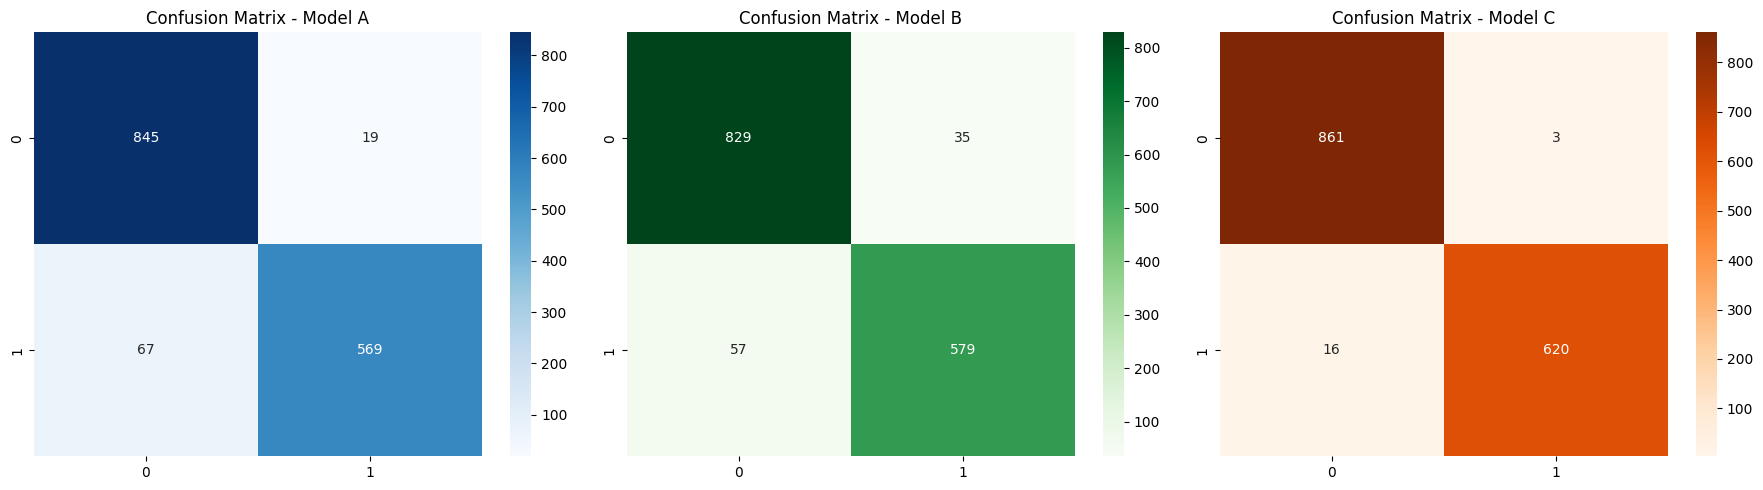

In [ ]:
# =======================
# Method A: CNN + Transformer + Link Constraint Regularization
# =======================
def link_constraint_loss(z, alpha=0.01):
    mean_z = tf.reduce_mean(z, axis=0)
    return alpha * tf.reduce_sum(tf.square(mean_z))

class CustomModelA(tf.keras.Model):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = layers.Conv1D(64, 3, activation='relu', padding='same')
        self.pool = layers.MaxPooling1D(2)
        self.transformer = layers.MultiHeadAttention(num_heads=4, key_dim=32)
        self.global_pool = layers.GlobalAveragePooling1D()
        self.dense1 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.pool(x)
        x = self.transformer(x, x)
        z = self.global_pool(x)
        x = self.dense1(z)
        return self.out(x), z

def train_model_a(input_shape):
    model = CustomModelA(input_shape)
    optimizer = tf.keras.optimizers.Adam()
    bce_loss = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            y_pred, z = model(x, training=True)
            loss = bce_loss(y, y_pred) + link_constraint_loss(z)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for epoch in range(10):
        loss_epoch = 0
        for i in range(0, len(X_train), 64):
            x_batch = X_train[i:i+64]
            y_batch = y_train[i:i+64]
            loss = train_step(x_batch, tf.convert_to_tensor(y_batch[:, None], dtype=tf.float32))
            loss_epoch += loss.numpy()
        print(f"Epoch {epoch+1}: Loss = {loss_epoch:.4f}")
    return model

# =======================
# Method B: Lightweight CNN + Transformer
# =======================
def MethodB(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, kernel_size=3, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inp, outputs=out)

# =======================
# Train and Evaluate
# =======================
print("Training Model A...")
model_a = train_model_a(X_train.shape[1:])
pred_a, _ = model_a(X_test, training=True)
pred_a = (pred_a.numpy() > 0.5).astype('int32')

print("Training Model B...")
model_b = MethodB(X_train.shape[1:])
model_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_b.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
pred_b = (model_b.predict(X_test) > 0.5).astype('int32')

print("Training KNN Classifier (Model C)...")
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_flat, y_train)
pred_c = knn.predict(X_test_flat)

# =======================
# Evaluation
# =======================
print("\nModel A Performance:\n", classification_report(y_test, pred_a))
print("\nModel B Performance:\n", classification_report(y_test, pred_b))
print("\nModel C Performance:\n", classification_report(y_test, pred_c))

# Confusion Matrices
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_matrix(y_test, pred_a), annot=True, fmt='d', ax=axs[0], cmap='Blues')
axs[0].set_title('Confusion Matrix - Model A')
sns.heatmap(confusion_matrix(y_test, pred_b), annot=True, fmt='d', ax=axs[1], cmap='Greens')
axs[1].set_title('Confusion Matrix - Model B')
sns.heatmap(confusion_matrix(y_test, pred_c), annot=True, fmt='d', ax=axs[2], cmap='Oranges')
axs[2].set_title('Confusion Matrix - Model C')
plt.tight_layout()
plt.show()